In [ ]:
import numpy as np
import keras

import os
import cv2
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

import time
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt 
from keras.preprocessing.image import load_img
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path= '/content/drive/MyDrive/columbiaT/train'
valid_path= '/content/drive/MyDrive/columbiaT/valid'
batch_size=128
train_batches =ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),batch_size=batch_size)
valid_batches =ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224),batch_size=batch_size)

Found 4689 images belonging to 5 classes.
Found 1175 images belonging to 5 classes.


In [ ]:
steps_train = train_batches.n / batch_size
steps_train


36.6328125

In [ ]:
steps_valid = valid_batches.n / batch_size
steps_valid


9.1796875

In [ ]:
num_classes = train_batches.num_classes
num_classes

5

In [ ]:
cls_train = train_batches.classes
cls_test =  valid_batches.classes
class_names = list(train_batches.class_indices.keys())
class_names

['-15P', '-30P', '0P', '15P', '30P']

In [ ]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]
image_paths_train = path_join(train_path, train_batches.filenames)
image_paths_test = path_join(valid_path, valid_batches.filenames)

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]
                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images)

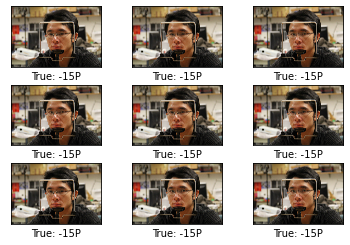

In [ ]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])
# Get the true classes for those images.
cls_true = cls_train[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import keras
from glob import glob
from tensorflow.keras.optimizers import RMSprop

from keras.layers import Input, Dense, Flatten
input_shape = (224, 224, 3)
InceptionV3 = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
for layer in InceptionV3.layers:
  layer.trainable= False
folders= glob('/content/drive/MyDrive/columbiaT/train/*')
x=Flatten()(InceptionV3.output)
prediction= Dense(len(folders), activation='softmax')(x)
model= Model(inputs= InceptionV3.input, outputs= prediction)
model.summary()
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])


87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs=10
#compile the model
#model.compile(Adam(),loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()
history = model.fit_generator(generator=train_batches,
                                  epochs=epochs,
                                  steps_per_epoch=steps_train,
                                  validation_data=valid_batches,
                                  validation_steps=steps_valid)
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))
result = model.evaluate_generator(valid_batches, steps=1)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
36/36 [==============================] - 2583s 71s/step - loss: 154.0678 - acc: 0.4839 - val_loss: 72.0860 - val_acc: 0.5787
Epoch 2/10
36/36 [==============================] - 1754s 48s/step - loss: 30.7567 - acc: 0.7865 - val_loss: 3.0215 - val_acc: 0.9089
Epoch 3/10
36/36 [==============================] - 1766s 48s/step - loss: 26.9006 - acc: 0.8900 - val_loss: 0.2620 - val_acc: 0.9872
Epoch 4/10
36/36 [==============================] - 1765s 48s/step - loss: 28.9757 - acc: 0.9057 - val_loss: 0.0552 - val_acc: 0.9966
Epoch 5/10
36/36 [==============================] - 1758s 48s/step - loss: 29.6603 - acc: 0.9115 - val_loss: 4.5665e-07 - val_acc: 1.0000
Epoch 6/10
36/36 [==============================] - 1769s 48s/step - loss: 22.8293 - acc: 0.9209 - val_loss: 0.0830 - val_acc: 0.9940
Epoch 7/10
36/36 [==============================] - 1768s 48s/step - loss: 21.9165 - acc: 0.9386 - val_loss: 0.0398 - val_acc: 0.9966
Epoch 8/10
36/36 [==============================] - 1777

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test-set classification accuracy: 99.22%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


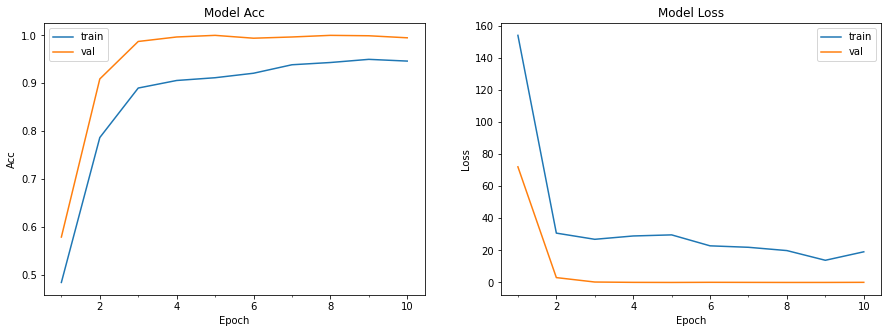

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Acc')
    axs[0].set_ylabel('Acc')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

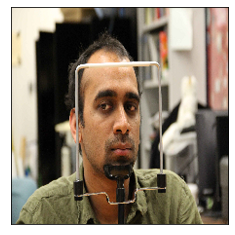

	-15P ==> 0.00 %
	-30P ==> 0.00 %
	0P ==> 0.00 %
	15P ==> 100.00 %
	30P ==> 0.00 %


In [ ]:
test_image = image.load_img('/content/drive/MyDrive/columbiaT/test/0004_2m_15P_-10V_-15H.jpg', target_size = (224,224))
plt.imshow(test_image, interpolation = 'spline16')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

test_image = np.expand_dims(test_image, axis = 0)
result= model.predict (test_image)
t=0
i=0
for label in class_names:
        print("\t%s ==> %.2f %%" % (label, result[t][i]*100))
        i = i + 1

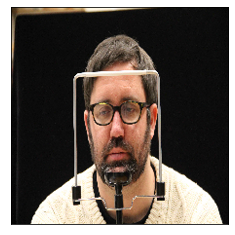

	-15P ==> 0.00 %
	-30P ==> 0.00 %
	0P ==> 100.00 %
	15P ==> 0.00 %
	30P ==> 0.00 %


In [ ]:
test_image = image.load_img('/content/drive/MyDrive/columbiaT/test/0036_2m_0P_-10V_-15H.jpg', target_size = (224,224))
plt.imshow(test_image, interpolation = 'spline16')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

test_image = np.expand_dims(test_image, axis = 0)
result= model.predict (test_image)
t=0
i=0
for label in class_names:
        print("\t%s ==> %.2f %%" % (label, result[t][i]*100))
        i = i + 1


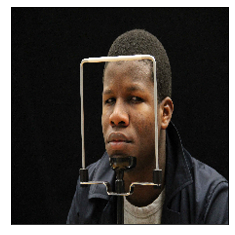

	-15P ==> 0.00 %
	-30P ==> 100.00 %
	0P ==> 0.00 %
	15P ==> 0.00 %
	30P ==> 0.00 %


In [ ]:
test_image = image.load_img('/content/drive/MyDrive/columbiaT/test/0042_2m_-30P_0V_10H.jpg', target_size = (224,224))
plt.imshow(test_image, interpolation = 'spline16')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

test_image = np.expand_dims(test_image, axis = 0)
result= model.predict (test_image)
t=0
i=0
for label in class_names:
        print("\t%s ==> %.2f %%" % (label, result[t][i]*100))
        i = i + 1


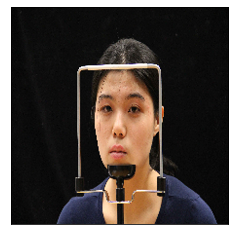

	-15P ==> 100.00 %
	-30P ==> 0.00 %
	0P ==> 0.00 %
	15P ==> 0.00 %
	30P ==> 0.00 %


In [ ]:

test_image = image.load_img('/content/drive/MyDrive/columbiaT/test/0013_2m_-15P_0V_-5H.jpg', target_size = (224,224))
plt.imshow(test_image, interpolation = 'spline16')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

test_image = np.expand_dims(test_image, axis = 0)
result= model.predict (test_image)
t=0
i=0
for label in class_names:
        print("\t%s ==> %.2f %%" % (label, result[t][i]*100))
        i = i + 1


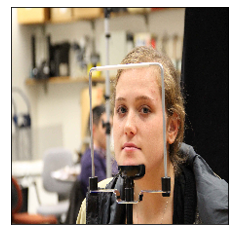

	-15P ==> 0.00 %
	-30P ==> 100.00 %
	0P ==> 0.00 %
	15P ==> 0.00 %
	30P ==> 0.00 %


In [ ]:

test_image = image.load_img('/content/drive/MyDrive/columbiaT/test/0035_2m_-30P_0V_0H.jpg', target_size = (224,224))
plt.imshow(test_image, interpolation = 'spline16')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

test_image = np.expand_dims(test_image, axis = 0)
result= model.predict (test_image)
t=0
i=0
for label in class_names:
        print("\t%s ==> %.2f %%" % (label, result[t][i]*100))
        i = i + 1
